In [1]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow
import keras.backend as K

from tensorflow.keras.preprocessing import image_dataset_from_directory

1.18.5
0.17.2


In [2]:
BATCH_SIZE = 1
NUM_EPOCHS = 40
IMAGE_SIZE = (256, 256)

In [7]:
train_dir = './dataset/train'
train_dataset = image_dataset_from_directory(train_dir, label_mode=None, shuffle=False, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

validation_dir = './dataset/validation'
validation_dataset = image_dataset_from_directory(validation_dir, label_mode=None, shuffle=False, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

test_dir = './dataset/test'
test_dataset = image_dataset_from_directory(test_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


(1, 256, 256, 3)


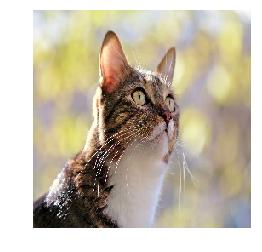

In [8]:
for images in train_dataset.take(1):
    print(images.shape)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
from model import ImageColorizationModel
from freeze import Freezer
model = ImageColorizationModel().model()
freezer = Freezer(model)


In [12]:
model.load_weights('convertedWeights.h5', by_name=True)
freezer.freeze_layers_old()

In [13]:
delta = 1
def l_delta_loss(y_true, y_pred):
    smaller = K.cast(K.abs(y_true - y_pred) < delta, tf.float32)
    bigger = 1 - smaller
    loss = K.sum(smaller * K.square(y_true - y_pred)) / 2 + delta * K.sum(bigger * (K.abs(y_true - y_pred) - (delta / 2)))
    return loss
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

In [14]:
base_learning_rate = 0.0001
model.compile(loss=l_delta_loss,
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bw_conv1_1 (Conv2D)             (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
ab_conv1_1 (Conv2D)             (None, 256, 256, 64) 1792        input_1[0][0]                    
_______________________________________________________________________________________

In [16]:
from utils.data_generator import DataGenerator

In [17]:
train_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=train_dataset)
validation_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=validation_dataset)

Initialized
Initialized


In [18]:
train_generator.__getitem__(0)
train_generator.__getitem__(0)
train_generator.__getitem__(0)


0
0
0


([array([[[[0.8406472 ],
           [0.8335119 ],
           [0.8338187 ],
           ...,
           [0.9798878 ],
           [0.97690725],
           [0.97690725]],
  
          [[0.85430413],
           [0.85075015],
           [0.8458277 ],
           ...,
           [0.9764356 ],
           [0.97690725],
           [0.9734529 ]],
  
          [[0.8680396 ],
           [0.86095285],
           [0.85816   ],
           ...,
           [0.9739295 ],
           [0.970219  ],
           [0.970219  ]],
  
          ...,
  
          [[0.20885013],
           [0.17645432],
           [0.16541424],
           ...,
           [0.60660243],
           [0.60660243],
           [0.5966281 ]],
  
          [[0.26837292],
           [0.16022271],
           [0.14003639],
           ...,
           [0.60660243],
           [0.6026909 ],
           [0.5997975 ]],
  
          [[0.22809684],
           [0.17435654],
           [0.14887522],
           ...,
           [0.5957855 ],
           [0.59

In [19]:
train_generator.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [20]:
history = model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=validation_generator)

0
Epoch 1/40
0
1/1 [==============================] - ETA: 0s - loss: 25875.3906 - accuracy: 0.55030
0
1/1 [==============================] - 2s 2s/step - loss: 25875.3906 - accuracy: 0.5503 - val_loss: 67230.3047 - val_accuracy: 0.4826
Epoch 2/40
0
1/1 [==============================] - 2s 2s/step - loss: 11261.1240 - accuracy: 0.5813 - val_loss: 66095.6719 - val_accuracy: 0.5006
Epoch 3/40
0
1/1 [==============================] - 2s 2s/step - loss: 10462.6621 - accuracy: 0.5780 - val_loss: 65697.7344 - val_accuracy: 0.5062
Epoch 4/40
0
1/1 [==============================] - 2s 2s/step - loss: 6847.8545 - accuracy: 0.5496 - val_loss: 65111.0469 - val_accuracy: 0.5251
Epoch 5/40
0
1/1 [==============================] - 2s 2s/step - loss: 8448.0938 - accuracy: 0.5531 - val_loss: 63702.4492 - val_accuracy: 0.5147
Epoch 6/40
0
1/1 [==============================] - 3s 3s/step - loss: 5696.5273 - accuracy: 0.5681 - val_loss: 61234.4766 - val_accuracy: 0.5172
Epoch 7/40
0
1/1 [=============

1/1 [==============================] - 2s 2s/step - loss: 1421.3083 - accuracy: 0.7666 - val_loss: 13210.7305 - val_accuracy: 0.4693
Epoch 37/40
0
1/1 [==============================] - 3s 3s/step - loss: 2060.3799 - accuracy: 0.7698 - val_loss: 13053.0342 - val_accuracy: 0.4826
Epoch 38/40
0
1/1 [==============================] - 2s 2s/step - loss: 1868.8820 - accuracy: 0.7825 - val_loss: 12985.9570 - val_accuracy: 0.4689
Epoch 39/40
0
1/1 [==============================] - 2s 2s/step - loss: 962.0009 - accuracy: 0.7585 - val_loss: 12905.2402 - val_accuracy: 0.4689
Epoch 40/40
0
1/1 [==============================] - 3s 3s/step - loss: 1605.2355 - accuracy: 0.7819 - val_loss: 13675.7295 - val_accuracy: 0.5594


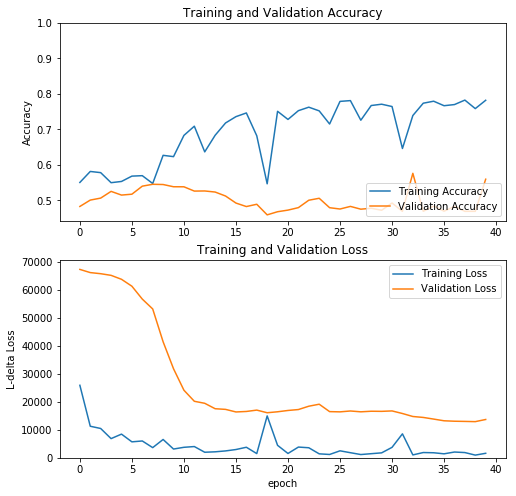

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('L-delta Loss')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=test_dataset)
test_batch = test_generator.__getitem__(0)
# do your magic vanka

In [ ]:
# test_batch[0][1][0] = np.zeros((256, 256, 3))

predictions = model.predict_on_batch(test_batch)

In [ ]:
print(test_batch[0][0].shape)
final_image = np.dstack((test_batch[0][0][0] * 100, predictions[0] * 128))
original_image = np.dstack((test_batch[0][0][0] * 100, test_batch[1][0] * 128))
print(original_image.shape)
print(np.amin(predictions[0] * 128), np.amax(predictions[0] * 128))
print(np.amin( test_batch[1][0] * 128), np.amax( test_batch[1][0] * 128))
print(np.sum((final_image-original_image)))

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize=(12, 4))
imshow(lab2rgb(final_image), ax=ax0), ax0.set_title('Final image'), ax0.axis('off')
imshow(lab2rgb(original_image), ax=ax1), ax1.set_title('Original image'), ax1.axis('off')
plt.show()

In [ ]:
plt.imshow(test_batch[0][1][0][:, :, 0])
plt.show()

In [ ]:
PSNR(original_image, final_image)